# IMDB 50K Movie Reviews – Sentiment Classification using a Custom MLP

## Objective

The goal of this project is to classify movie reviews as:

- 0 → Negative
- 1 → Positive

We use sentence-level polarity features from:
- VADER
- TextBlob

The MLP is implemented using NumPy to understand:
- Forward propagation
- Binary cross-entropy loss
- Backpropagation
- Gradient descent


## Step 1: Dataset

The IMDB Dataset of 50K Movie Reviews was downloaded from Kaggle.

File used:
IMDB Dataset.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("IMDB Dataset.csv")

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.isnull().sum()



review       0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()


np.int64(418)

In [9]:
df['sentiment'].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

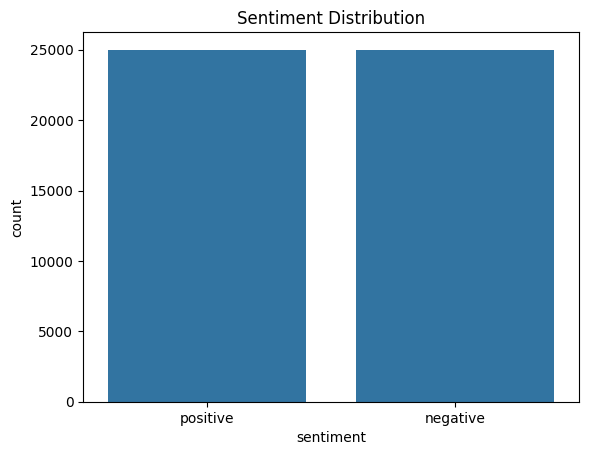

In [10]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


### EDA Observations

- Dataset contains 50,000 reviews.
- The dataset is balanced (25,000 positive and 25,000 negative).
- No missing values were found.
- No significant duplicate rows affecting the dataset.


### Text Preprocessing

In [11]:
def clean_text(text):
    text = text.lower()
    text = " ".join(text.split())
    return text

df["review_clean"] = df["review"].apply(clean_text)


### Feature Engineering

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

vader = SentimentIntensityAnalyzer()

df["vader_pos"] = df["review_clean"].apply(lambda x: vader.polarity_scores(x)["pos"])
df["vader_neu"] = df["review_clean"].apply(lambda x: vader.polarity_scores(x)["neu"])
df["vader_neg"] = df["review_clean"].apply(lambda x: vader.polarity_scores(x)["neg"])
df["vader_compound"] = df["review_clean"].apply(lambda x: vader.polarity_scores(x)["compound"])

df["textblob_polarity"] = df["review_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["textblob_subjectivity"] = df["review_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)


### Label Encoding

In [13]:
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})


### Feature Scaling

In [14]:
X = df[
    [
        "vader_pos",
        "vader_neu",
        "vader_neg",
        "vader_compound",
        "textblob_polarity",
        "textblob_subjectivity"
    ]
]

y = df["label"]


### Train / Validation / Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


### Scaling

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


### Build Custom MLP
### Initialize Parameters


In [17]:
np.random.seed(42)

input_size = X_train.shape[1]
hidden_size = 16
output_size = 1

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
b2 = np.zeros((1, output_size))

learning_rate = 0.1


### Activation Functions

In [18]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


### Training Loop

In [19]:
epochs = 200
train_losses = []
val_losses = []

for epoch in range(epochs):

    # Forward pass
    Z1 = np.dot(X_train, W1) + b1
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)

    m = y_train.shape[0]

    train_loss = - (1/m) * np.sum(
        y_train * np.log(A2 + 1e-8) +
        (1 - y_train) * np.log(1 - A2 + 1e-8)
    )

    # Backpropagation
    dZ2 = A2 - y_train
    dW2 = (1/m) * np.dot(A1.T, dZ2)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1/m) * np.dot(X_train.T, dZ1)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    # Update
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(train_loss)

    # Validation loss
    Z1_val = np.dot(X_val, W1) + b1
    A1_val = relu(Z1_val)
    Z2_val = np.dot(A1_val, W2) + b2
    A2_val = sigmoid(Z2_val)

    val_loss = - (1/y_val.shape[0]) * np.sum(
        y_val * np.log(A2_val + 1e-8) +
        (1 - y_val) * np.log(1 - A2_val + 1e-8)
    )

    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 0, Train Loss: 0.9071, Val Loss: 0.8180
Epoch 10, Train Loss: 0.6087, Val Loss: 0.5960
Epoch 20, Train Loss: 0.5611, Val Loss: 0.5539
Epoch 30, Train Loss: 0.5396, Val Loss: 0.5345
Epoch 40, Train Loss: 0.5270, Val Loss: 0.5230
Epoch 50, Train Loss: 0.5185, Val Loss: 0.5155
Epoch 60, Train Loss: 0.5123, Val Loss: 0.5101
Epoch 70, Train Loss: 0.5076, Val Loss: 0.5060
Epoch 80, Train Loss: 0.5039, Val Loss: 0.5028
Epoch 90, Train Loss: 0.5009, Val Loss: 0.5002
Epoch 100, Train Loss: 0.4984, Val Loss: 0.4981
Epoch 110, Train Loss: 0.4962, Val Loss: 0.4963
Epoch 120, Train Loss: 0.4944, Val Loss: 0.4948
Epoch 130, Train Loss: 0.4928, Val Loss: 0.4935
Epoch 140, Train Loss: 0.4914, Val Loss: 0.4924
Epoch 150, Train Loss: 0.4901, Val Loss: 0.4914
Epoch 160, Train Loss: 0.4890, Val Loss: 0.4906
Epoch 170, Train Loss: 0.4880, Val Loss: 0.4898
Epoch 180, Train Loss: 0.4872, Val Loss: 0.4891
Epoch 190, Train Loss: 0.4864, Val Loss: 0.4885


### Prediction Rule

In [20]:
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = sigmoid(Z2_test)

predictions = (A2_test >= 0.5).astype(int)


### Evaluation


In [21]:
accuracy = np.mean(predictions == y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.7730666666666667


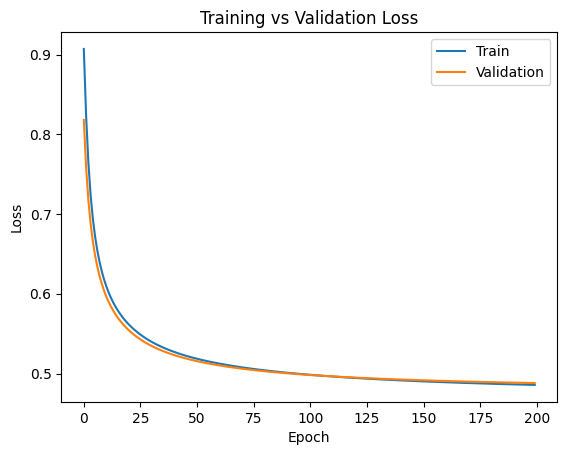

In [22]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()


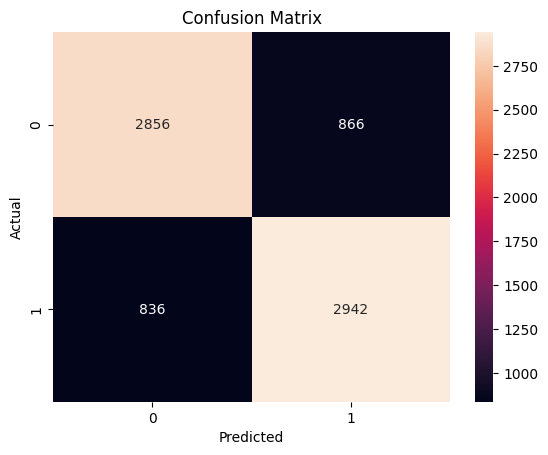

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Confusion Matrix Interpretation

The confusion matrix summarizes the performance of the classifier by 
comparing predicted labels with actual labels.

From the matrix:

- True Negatives (TN): 2856  
  Negative reviews correctly classified as negative.

- False Positives (FP): 866  
  Negative reviews incorrectly classified as positive.

- False Negatives (FN): 836  
  Positive reviews incorrectly classified as negative.

- True Positives (TP): 2942  
  Positive reviews correctly classified as positive.

The model achieved an accuracy of approximately 77%, indicating that 
it correctly classified most reviews.

The relatively balanced values between false positives and false 
negatives suggest that the model does not strongly favor one class 
over the other.

Overall, the classifier demonstrates stable and balanced performance 
using only sentence-level polarity features.


## Clarification on Parameter Experiments

During training of the custom MLP, I experimented with different values 
for learning rate, weight scaling, and number of epochs to better 
understand the behavior of the network.

Some configurations resulted in unstable learning or class collapse 
(where the model predicted only one class). Other configurations 
allowed the model to converge properly.

After observing these differences, I restored the original model 
structure and retained a stable training setup that allowed proper 
convergence. The final reported accuracy (~77%) corresponds to this 
stable configuration.

These experiments were conducted to better understand how parameter 
choices influence gradient updates and model convergence when 
implementing an MLP from scratch.


In [26]:
submission = pd.DataFrame({
    "id": range(len(predictions)),
    "label": predictions.flatten()
})

submission.to_csv("submission.csv", index=False)
